# Timeseries with ARIMA
Using tutorial https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

and this book `Time Series Analysis and Its Applications: With R Examples` for theory.

In [1]:
import numpy as np
import pandas as pd
import re
import os
from pandas.plotting import scatter_matrix

get_ipython().magic(u'env OMP_NUM_THREADS=2')

from IPython.display import display, HTML

%matplotlib inline
import matplotlib.pyplot as plt

#get_ipython().magic(u'matplotlib')
#get_ipython().magic(u'matplotlib inline')

# Set the ransom seed used for the whole program to allow reprocibility
np.random.seed(3214412)

from scipy.stats import pearsonr

env: OMP_NUM_THREADS=2


In [2]:
data_file = 'AirQualityUCI.csv'

In [3]:
# For European data use , as the decimal point
raw_df = pd.read_csv(data_file, sep=';', decimal=',')

In [4]:
raw_df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN


In [5]:
print(raw_df.columns)

Index(['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)',
       'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
       'PT08.S5(O3)', 'T', 'RH', 'AH', 'Unnamed: 15', 'Unnamed: 16'],
      dtype='object')


# Subset Test Dataset
Every column in the dataset can be analyzed as a timeseries column.

For now just do a timeseries analysis of timestamp to CO(GT) concenteration

Missing values are labeled with -200

In [6]:
# Limit to the timestamp column and the CO(GT) concentration
data_df = pd.DataFrame.copy(raw_df[['Date', 'Time', 'CO(GT)']])

# Cleanup the timestamp
data_df = data_df[~data_df.Date.isnull()]
data_df['timestamp'] = data_df['Date'] + 'T' + data_df['Time']
print(data_df.timestamp.iloc[0])
data_df['timestamp'] = pd.to_datetime(data_df['timestamp'].str.replace('/', '-').str.replace('.', ':'))
data_df = data_df.rename(columns={'CO(GT)': 'CO_GT'})
print('Dropping rows where the CO_GT is missing')
data_df = data_df[data_df.CO_GT >= 0]
data_df = data_df.set_index('timestamp')
data_df.drop(labels=['Date', 'Time'], axis=1, inplace=True)
data_df.sort_index(inplace=True)
display(data_df.describe())
display(data_df.head())

10/03/2004T18.00.00
Dropping rows where the CO_GT is missing


,CO_GT
count,7674.000000
mean,2.152750
std,1.453252
min,0.100000
25%,1.100000
50%,1.800000
75%,2.900000
max,11.900000


,CO_GT
timestamp,
2004-01-04 00:00:00,1.6
2004-01-04 01:00:00,1.2
2004-01-04 02:00:00,1.1
2004-01-04 03:00:00,0.9
2004-01-04 04:00:00,0.7


# Visualizations

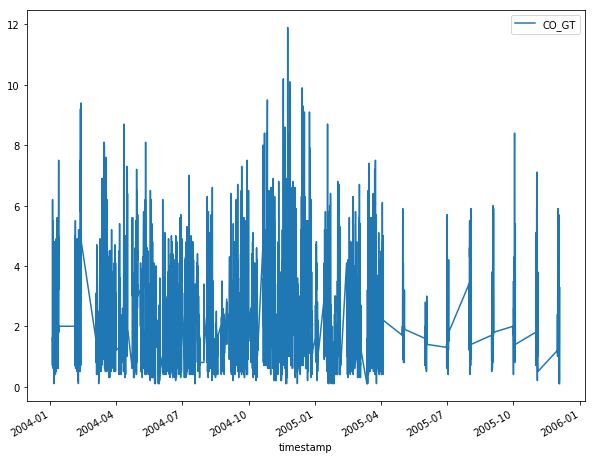

In [7]:
from matplotlib import pyplot
data_df.plot(figsize=(10, 8))
pyplot.show()

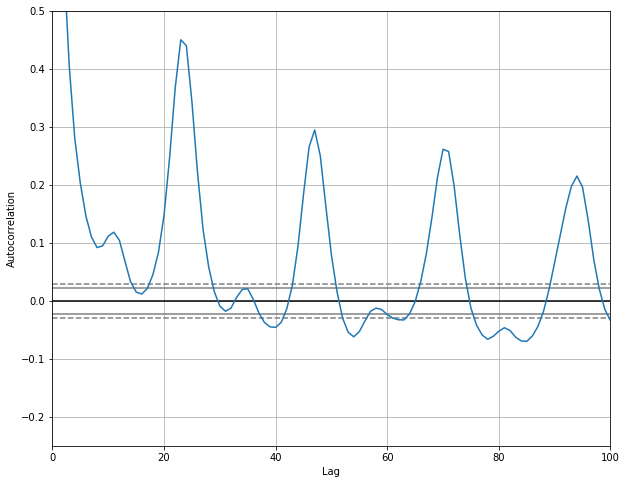

In [8]:
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(10, 8))
autocorrelation_plot(data_df)
plt.axis([0,100,-0.25,0.5])  # Manually zoom into figure
pyplot.show()

# Modeling

/home/napoleon/.virtualenvs/arima-poc/lib/python3.5/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/home/napoleon/.virtualenvs/arima-poc/lib/python3.5/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


                             ARIMA Model Results                              
Dep. Variable:                D.CO_GT   No. Observations:                 7673
Model:                ARIMA(15, 1, 0)   Log Likelihood               -8991.679
Method:                       css-mle   S.D. of innovations              0.781
Date:                Thu, 25 Jan 2018   AIC                          18017.359
Time:                        06:10:02   BIC                          18135.432
Sample:                    01-04-2004   HQIC                         18057.858
                         - 12-03-2005                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0002      0.004     -0.044      0.965      -0.008       0.007
ar.L1.D.CO_GT      0.1389      0.011     12.186      0.000       0.117       0.161
ar.L2.D.CO_GT     -0.2146      0.011

/home/napoleon/.virtualenvs/arima-poc/lib/python3.5/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


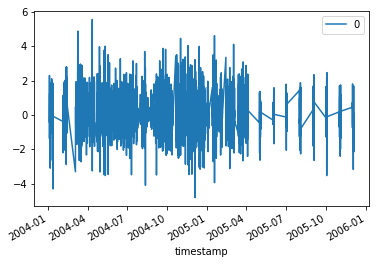

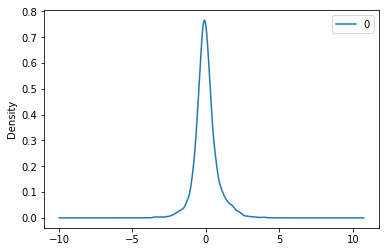

                 0
count  7673.000000
mean      0.000105
std       0.781129
min      -4.799157
25%      -0.398195
50%      -0.056354
75%       0.323132
max       5.552966


In [10]:
from statsmodels.tsa.arima_model import ARIMA

# fit model
lag = 15  # Based on reading the above autocorrelation plot
model = ARIMA(data_df, order=(lag,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

Above model looks fine.  Mean of the residuals is really close to 0 and the coefficients are mostly significant.

# Rolling ARIMA with predictions
It takes a long time to model every n with the n-1 data, so just split into a test/train

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
 
# This isn't quite right with my dataset because the observations are not always in a regular cadence
X = data_df.CO_GT.values
size = int(len(X) * 0.99)  # Use the first chunk for training
train, test = X[0:size], X[size:len(X)]
print("Using first {trainlen} obs for training and next {testlen} for testing".format(
        trainlen=len(train), testlen=len(test)))
rolling_train = [x for x in train]
predictions = list()
for i, t in enumerate(range(len(test))):
    model = ARIMA(rolling_train, order=(lag,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    rolling_train.append(obs)
    print('%i: predicted=%f, expected=%f' % (i, yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

Using first 7597 obs for training and next 77 for testing


/home/napoleon/.virtualenvs/arima-poc/lib/python3.5/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/home/napoleon/.virtualenvs/arima-poc/lib/python3.5/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/home/napoleon/.virtualenvs/arima-poc/lib/python3.5/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


0: predicted=0.565205, expected=1.500000
1: predicted=1.909334, expected=2.200000
2: predicted=2.354596, expected=1.700000
3: predicted=1.594595, expected=1.100000
4: predicted=0.869500, expected=1.300000
5: predicted=1.489449, expected=1.500000
6: predicted=1.652464, expected=3.400000
7: predicted=3.759603, expected=3.800000
8: predicted=3.549169, expected=2.800000
9: predicted=2.165571, expected=0.800000
10: predicted=0.287569, expected=0.500000
11: predicted=0.753142, expected=1.200000
12: predicted=1.670999, expected=2.400000
13: predicted=2.706988, expected=2.100000
14: predicted=1.857697, expected=1.100000
15: predicted=0.848306, expected=1.000000
16: predicted=1.245911, expected=1.400000
17: predicted=1.778048, expected=1.800000
18: predicted=1.994863, expected=3.800000
19: predicted=3.929088, expected=4.100000
20: predicted=3.547092, expected=4.400000
21: predicted=3.919228, expected=3.500000
22: predicted=3.045190, expected=3.500000
23: predicted=3.503890, expected=3.800000
24